# 单星测光

## 利用SExtractor对给定的模拟图像进行测光

spa2022a.param文件设置：增加A_IMAGE、B_IMAGE、KRON_RADIUS三列用以计算SExtrator测光结果的信噪比中的背景

选取测光结果中的一颗亮星，其参数如下：

![avatar](2.png)


## 利用 Aperture Photometry tool
![avatar](1.png)

1.孔径选取参数：
![avatar](3.png)
2.孔径测光界面展示：
![avatar](4.png)
3.孔径测光结果展示：背景算法为求平均值
![avatar](5.png)
4.相关结果展示：生长曲线、3D图像
![avatar](6.png)
![avatar](apertureImageSurfaceChart3D.png)

## 手动测光

In [1]:
#导入相关包
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import numpy.ma as ma

Filename: 5.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (2048, 2048)   float32   


<AxesSubplot:>

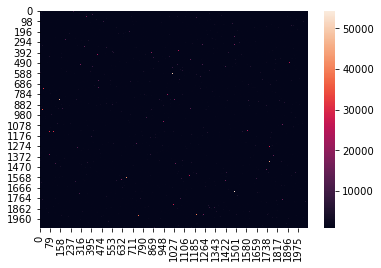

In [2]:
# 打开文件，读取数据
hdulist = fits.open('5.fit')

# 查看文件基本信息
hdulist.info()
hdu1 = hdulist[0]

#取出data并显示
data= hdu1.data
sns.heatmap(data)

<AxesSubplot:>

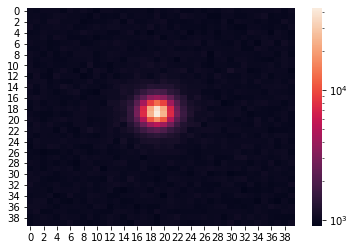

In [3]:
#Slice DATA to target star
data_star = data[650:690,827:867]
#利用热力图显示目标星
sns.heatmap(data_star,norm=LogNorm())

背景平均值为：1003.5146213657877
背景标准差为：33.304421431128276


<AxesSubplot:>

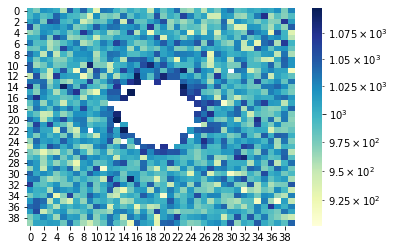

In [4]:
#Mask 1: 筛选背景
#筛选条件
condition = data_star > 1100
#转换为mask数组
m1=condition.astype(np.int8)
#创建mask矩阵
data_ma1=ma.array(data_star, mask=m1)
#打印平均值、标准差
print('背景平均值为：'+str(data_ma1.mean()))
print('背景标准差为：'+str(data_ma1.std()))
#显示被mask后的星空图像，值为对数坐标
sns.heatmap(data_star,norm=LogNorm(),mask=m1,cmap="YlGnBu")

<AxesSubplot:>

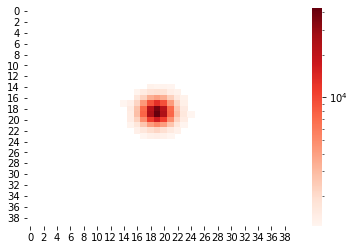

In [5]:
#Mask 2: 6.5sigma筛选 
#筛选条件
condition = data_star < data_ma1.mean()+6.5*data_ma1.std()
#转换为mask数组
m2=condition.astype(np.int8)
#创建mask矩阵
data_ma2=ma.array(data_star, mask=m2)
#显示被mask后的目标星
sns.heatmap(data_star,norm=LogNorm(),mask=m2,cmap="Reds")


总流量：326731.2710324913
668.6003824569477 846.0019751164733


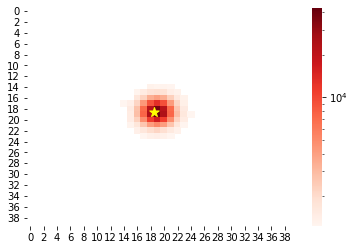

In [6]:
#计算目标星位置
x_multiple_idx=0
y_multiple_idx=0

sum=0
for index_x, x in enumerate(data_star):
    for index_y, value in enumerate(x):
        if m2[index_x][index_y]==0: #利用m2筛选符合的数据
            c=0
            c=value-data_ma1.mean()
            x_multiple_idx+=c*index_x
            y_multiple_idx+=c*index_y
            sum+=c
            
print('总流量：'+str(sum))
#加权平均

xc=x_multiple_idx/sum+650
yc=y_multiple_idx/sum+827
print(xc,yc)

#显示结果
fig,ax1=plt.subplots()
sns.heatmap(data_star,norm=LogNorm(),mask=m2,cmap="Reds",ax=ax1)
#中心像素
ax1.scatter(19,19,marker='*', s=100, color='yellow')
plt.show()


[0, 78211.65435101843, 231305.55891861056, 289164.9362507394, 316329.5399278039, 326201.55405940255, 331144.7283196841, 334347.7708316397, 335882.50743539195, 336803.8533727938, 336920.55526722694, 336527.45153106557, 336681.9212329902, 336361.5754648674, 336737.0856458933]


Text(0, 0.5, 'Flux')

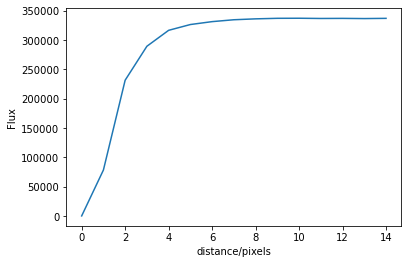

In [7]:
#生长曲线
xc=x_multiple_idx/sum
yc=y_multiple_idx/sum

growth=[]
flux=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for index_x, x in enumerate(data_star):
    for index_y, value in enumerate(x):
        for i in range(15):
            if ((xc-index_x)**2+(yc-index_y)**2) <i**2:
                d=0
                d=value-data_ma1.mean()  
                flux[i]+=d          
print(flux)
plt.plot(range(15),flux)  
plt.xlabel('distance/pixels')
plt.ylabel('Flux')

## 三种方法对比与误差分析
![avatar](7.png)
![avatar](8.png)

# 批量测光与星表匹配

## 数据导入与匹配

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#增益sex设定
gain=1.2

In [9]:
#导入整理后的数据，包括星表数据
data = pd.read_csv('data.csv')

display(data)
#提取数据
starmap_coord=data[['X(星表)','Y(星表)','MAG(星表)']].to_numpy()
test_coord=data[['X_IMAGE',	'Y_IMAGE',	'FLUX_AUTO',	'FLUXERR_AUTO',	'MAG_APER8','MAG_APER12',	'MAG_APER16',	'MAG_APER20',	'MAGERR_APER8',	'MAGERR_APER12',	'MAGERR_APER16'	,'MAGERR_APER20',	'MAG_AUTO',	'MAGERR_AUTO','BACKGROUND',	'FWHM_IMAGE',	'0.5FLUX_RADIUS',	'A_IMAGE',	'B_IMAGE',	'KRON_RADIUS']].to_numpy()



,X(星表),Y(星表),MAG(星表),X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUXERR_AUTO,MAG_APER8,MAG_APER12,MAG_APER16,...,MAGERR_APER16,MAGERR_APER20,MAG_AUTO,MAGERR_AUTO,BACKGROUND,FWHM_IMAGE,0.5FLUX_RADIUS,A_IMAGE,B_IMAGE,KRON_RADIUS
0,1002.662,1.636,-1.636,297.199,34.793,257292.40,591.2693,12.5066,12.4545,12.4391,...,0.0029,0.0032,12.4739,0.0025,1002.333,2.20,1.398,1.398,1.377,3.5
1,70.853,2.671,-3.454,1375.036,29.387,227956.40,586.6953,12.7088,12.6022,12.5825,...,0.0031,0.0035,12.6054,0.0028,1001.624,4.28,1.879,2.043,1.378,3.5
2,146.862,3.343,-5.187,908.760,23.217,67357.80,372.7751,13.9543,13.9023,13.8921,...,0.0084,0.0100,13.9290,0.0060,1001.603,2.21,1.399,1.292,1.274,3.5
3,1839.723,3.645,-3.380,1949.219,18.811,70713.69,366.2453,13.9009,13.8507,13.8372,...,0.0078,0.0092,13.8762,0.0056,1001.410,2.20,1.384,1.286,1.257,3.5
4,245.955,4.069,-3.943,1543.711,14.785,67287.65,380.1236,13.9787,13.9101,13.8920,...,0.0082,0.0097,13.9302,0.0061,1000.308,2.60,1.582,1.551,1.254,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1163.490,2044.385,-5.217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,1874.302,2044.389,-4.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,1337.218,2044.806,-0.444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,986.051,2045.585,-2.972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#匹配算法
data_processed=[]
num=0
for test in test_coord:
    for star in starmap_coord:
        #print(test[0])
        #print(np.shape(star))
        delta_x = star[0]-test[0]
        delta_y = star[1]-test[1]
        delta = delta_x**2+delta_y**2
        #匹配标准：r<1 pixel
        if delta<1:
            
            num+=1
            temp=np.hstack((star,test))
            temp=np.insert(temp,23,delta_x)
            temp=np.insert(temp,24,delta_y)
            data_processed.append(temp)      
print('匹配数：'+str(num))
data_processed_np=np.array(data_processed)
#print(data_processed)
np.shape(data_processed_np)

匹配数：1690


(1690, 25)

## xy误差与信噪比的关系

[555.47765109 522.48670466 284.01006203 ...  58.91349694 311.36571674
 106.77270489]


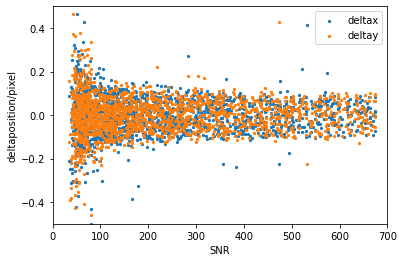

In [11]:
#创建新图层
fig, ax=plt.subplots()

#计算信噪比
#中天光背景为BACKGROUND*PI*A_IMAGE*B_IMAGE*KRON_RADIUS^2(根据软件手册，自动孔径为椭圆，长度为A和B。单位为KRON_RADIUS)
SNR=gain*data_processed_np[:,5]/np.sqrt(gain*(data_processed_np[:,5]+np.pi*data_processed_np[:,-7]*data_processed_np[:,-5]*data_processed_np[:,-4]*data_processed_np[:,-3]**2))
#+data_processed_np[:,6]*data_processed_np[:,8]
print(SNR)

#绘图SNR与deltax、deltay的关系
ax.scatter(SNR,data_processed_np[:,-2],s=5)
ax.scatter(SNR,data_processed_np[:,-1],s=5)

ax.set_ylim([-0.5,0.5])
ax.set_xlim([0,700])
#np.savetxt('2.csv',SNR,delimiter=',')

ax.set_xlabel('SNR')
ax.set_ylabel('deltaposition/pixel')
ax.legend(['deltax','deltay'])

plt.show()

## 星等差、星等误差与输入星等关系


### 星等差-输入星等

[-0.033  0.211 -0.033 ... -0.134  0.     0.123]
-6.994
-0.748


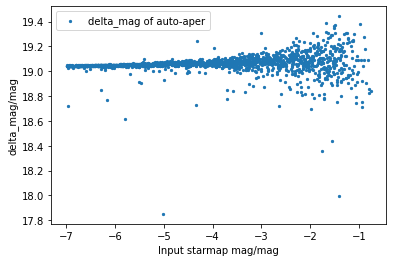

In [12]:
#创建新图层
fig, ax=plt.subplots()

delta_mag=data_processed_np[:,-10]-data_processed_np[:,2]

print(data_processed_np[:,-2])

ax.scatter(data_processed_np[:,2],delta_mag,s=5)
#ax.set_ylim([18.7,19.5])

print(np.min(data_processed_np[:,2]))
print(np.max(data_processed_np[:,2]))

ax.set_xlabel('Input starmap mag/mag')
ax.set_ylabel('delta_mag/mag')
ax.legend(['delta_mag of auto-aper'])

plt.show()

#np.savetxt('2.csv',data_processed_np,delimiter=',')

[-0.033  0.211 -0.033 ... -0.134  0.     0.123]
-6.994
-0.748


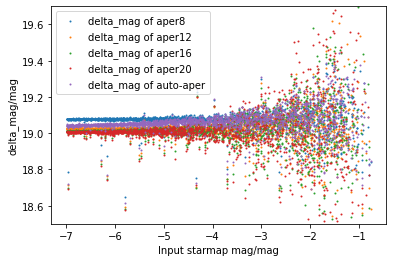

In [13]:
#创建新图层
fig, ax=plt.subplots()

delta_mag8=data_processed_np[:,7]-data_processed_np[:,2]
delta_mag12=data_processed_np[:,8]-data_processed_np[:,2]
delta_mag16=data_processed_np[:,9]-data_processed_np[:,2]
delta_mag20=data_processed_np[:,10]-data_processed_np[:,2]

print(data_processed_np[:,-2])

ax.scatter(data_processed_np[:,2],delta_mag8,s=1)
ax.scatter(data_processed_np[:,2],delta_mag12,s=1)
ax.scatter(data_processed_np[:,2],delta_mag16,s=1)
ax.scatter(data_processed_np[:,2],delta_mag20,s=1)
ax.scatter(data_processed_np[:,2],delta_mag,s=1)

ax.set_ylim([18.5,19.7])

print(np.min(data_processed_np[:,2]))
print(np.max(data_processed_np[:,2]))

ax.set_xlabel('Input starmap mag/mag')
ax.set_ylabel('delta_mag/mag')
ax.legend(['delta_mag of aper8','delta_mag of aper12','delta_mag of aper16','delta_mag of aper20','delta_mag of auto-aper'])

plt.show()



### 星等误差-输入星等

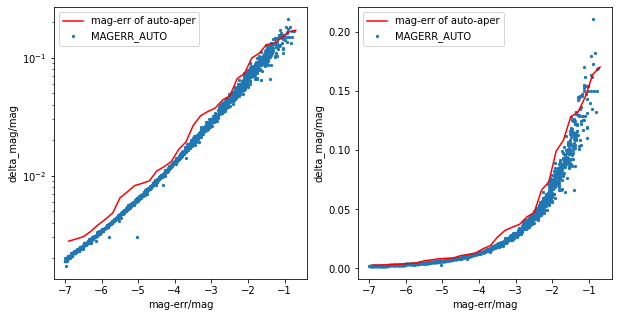

In [17]:

p=np.min(data_processed_np[:,2])

#计算宽度为0.2区间内的标准差
std=[]
while p< np.max(data_processed_np[:,2]):
        p=p+0.2
        
        
        temp=[]
        num=0
        for data in data_processed_np:
            #筛选落在0.2区间内的数据
            if((data[2]<p and data[2]>p-0.5)):
                temp.append(data[-10]-data[2])
                num=num+1      
        temp=np.array(temp)
        
        #迭代筛选掉偏差过大的坏点，单次筛选为3sigma之内的数据，迭代5次
        for times in range(4):
            std_temp=np.std(temp, ddof=1)
            mean_temp=np.mean(temp)
            temp=temp[np.logical_and(temp>mean_temp-3*std_temp,temp<mean_temp+3*std_temp)]
        std_temp=0 
        mean_temp=0
        #将得到的标准差添加至数组
        std.append([p-0.1,np.std(temp, ddof=1)])
#print(std)

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
std=np.array(std)

#Linear Scale
ax[0].plot(std[:,0],std[:,1],c='red')
ax[0].scatter(data_processed_np[:,2],data_processed_np[:,-9],s=5)

ax[0].set_xlabel('mag-err/mag')
ax[0].set_ylabel('delta_mag/mag')
ax[0].legend(['mag-err of auto-aper','MAGERR_AUTO'])
ax[0].set_yscale('log')

#Log Scale
ax[1].plot(std[:,0],std[:,1],c='red')
ax[1].scatter(data_processed_np[:,2],data_processed_np[:,-9],s=5)

ax[1].set_xlabel('mag-err/mag')
ax[1].set_ylabel('delta_mag/mag')
ax[1].legend(['mag-err of auto-aper','MAGERR_AUTO'])


plt.show()



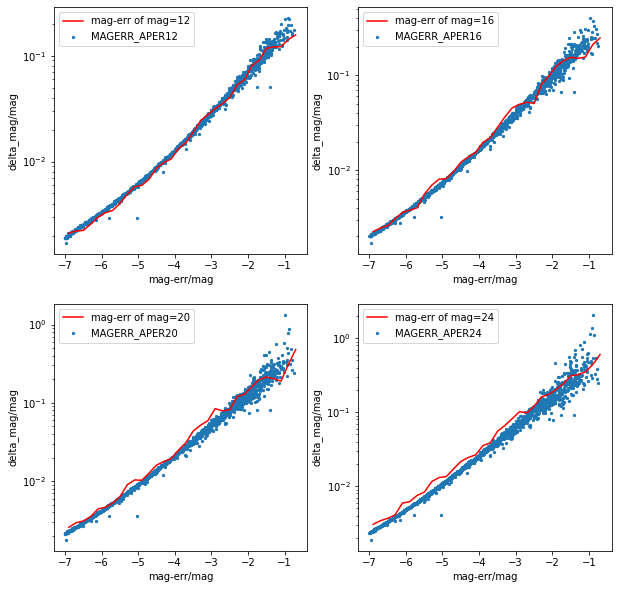

In [58]:
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,10))

row=0
col=0
for num in range(1,5):
    p=np.min(data_processed_np[:,2])

#计算宽度为0.2区间内的标准差
    std=[]
    while p< np.max(data_processed_np[:,2]):
        p=p+0.2
        
        
        temp=[]
        num0=0
        for data in data_processed_np:
            #筛选落在0.2区间内的数据
            if((data[2]<p and data[2]>p-0.5)):
                temp.append(data[num+6]-data[2])
                num0=num0+1      
        temp=np.array(temp)
        
        #迭代筛选掉偏差过大的坏点，单次筛选为3sigma之内的数据，迭代5次
        for times in range(4):
            std_temp=np.std(temp, ddof=1)
            mean_temp=np.mean(temp)
            temp=temp[np.logical_and(temp>mean_temp-3*std_temp,temp<mean_temp+3*std_temp)]
        std_temp=0 
        mean_temp=0
        #将得到的标准差添加至数组
        std.append([p-0.1,np.std(temp, ddof=1)])
        std_np=np.array(std)


    ax[row][col].plot(std_np[:,0],std_np[:,1],c='red')
    ax[row][col].scatter(data_processed_np[:,2],data_processed_np[:,-15+num],s=5)

    ax[row][col].set_xlabel('mag-err/mag')
    ax[row][col].set_ylabel('delta_mag/mag')
    ax[row][col].legend(['mag-err of mag='+str(8+num*4),'MAGERR_APER'+str(8+num*4)])
    ax[row][col].set_yscale('log')
        
    if (num % 2) == 0:
        row=row+1
        col-=1
            
    else:
        col+=1  

plt.show()

range(7, 9)


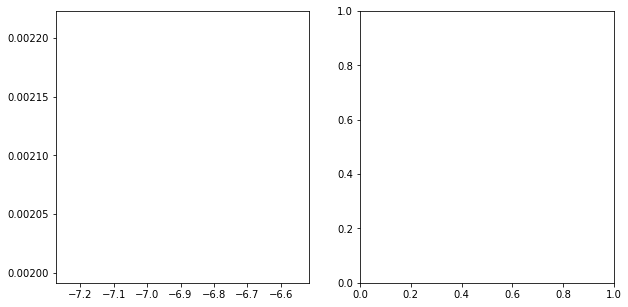

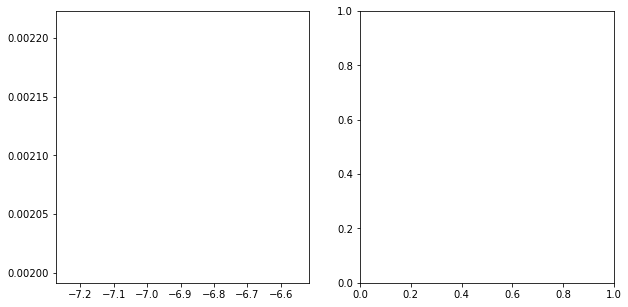

In [59]:
a=np.array([0.502336226,0.434791696,0.475304358,0.405864238])

In [62]:
np.mean(a)



0.4545741295

In [63]:
np.std(a)

0.03699648105178797

In [65]:
print(np.mean(a)+3*np.std(a),np.mean(a)-3*np.std(a))

0.5655635726553638 0.34358468634463607
